In [1]:
import pandas as pd
import numpy as np
import alphalens

In [2]:
data_price = pd.read_csv(r'/home/ibrahim/Desktop/internship_project/data/Price.csv',index_col='Unnamed: 0')

/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
bond_price = pd.read_csv(r'/home/ibrahim/Desktop/internship_project/data/Bond.csv')

In [4]:
pivotdata = data_price.pivot_table(values='adjusted_close',index='date',columns='symbol')
pivotdata.index = pd.to_datetime(pivotdata.index)

In [5]:
pivotdata = pivotdata['2000-01-01':]

In [6]:
bond_price['date'] = pd.to_datetime(bond_price['date'])

In [7]:
bond_price = bond_price.set_index('date').reindex(pivotdata.index).fillna(method='ffill').reset_index()

In [ ]:
def scores_to_alphalens(scores):
    scores_alphalens = scores.unstack()
    scores_alphalens = scores_alphalens.reset_index(level=[0,1])
    scores_alphalens.columns = ['symbol', 'date', 'factor']
    scores_alphalens = scores_alphalens.set_index(['date','symbol'])
    
    return scores_alphalens

In [8]:
def cal_sharpe_mom(range_arr,pivotdata,bond_price):
    
    def piv_to_df(returns,month):
            returns_df = returns.unstack()
            returns_df = returns_df.reset_index(level=[0,1])
            returns_df.columns = ['symbol', 'date', 'returns_'+month+'mo']
            returns_df = returns_df.set_index(['date','symbol'])
            return returns_df
        
    if range_arr[0]==10 : 
        range_m = 'half_month'
    else:
        range_m = str(range_arr[0]//20)
    returns_mo = pivotdata.pct_change(range_arr[0])
    bond_mo = bond_price.set_index('date').pct_change(range_arr[0])
    bond_mo.columns=['bond_'+range_m+'mo']
        
    df_returns_mo = piv_to_df(returns_mo,range_m)
        
    df_returns = df_returns_mo.reset_index()
    df_bonds = bond_mo
    df_bonds = df_bonds.dropna().reset_index()
        
    df_returns = df_returns[(df_returns['date'] >= bond_price['date'].iloc[0]) & (df_returns['date'] <= bond_price['date'].iloc[-1])]

    df_returns = df_returns.set_index('date')
    df_bonds = df_bonds.set_index('date')

    df_total = df_returns.join(df_bonds).reset_index()
    df_total = df_total.set_index(['symbol','date'])

    df_total['excess_'+range_m+'mo'] = df_total['returns_'+range_m+'mo'] - df_total['bond_'+range_m+'mo']
    df_total = df_total.reset_index()

    std = df_total.groupby('symbol').std()
    df_total = df_total.reset_index().set_index('symbol')
        
    df_total['risk_'+range_m+'mo'] = std['excess_'+range_m+'mo'] 
    df_total['sh_'+range_m+'mo'] = df_total['excess_'+range_m+'mo'] / df_total['risk_'+range_m+'mo']
        
    df_total = df_total.reset_index().set_index(['symbol','date'])
    df_total['tot_sh'] = df_total['sh_'+range_m+'mo']

    score_alphalens = pd.DataFrame(df_total['tot_sh'])
    score_alphalens = score_alphalens.swaplevel()
        
    return score_alphalens

In [9]:
fir_scores_alphalens = cal_sharpe_mom([10],pivotdata,bond_price)

In [10]:
scores_pivot = pd.pivot_table(fir_scores_alphalens,values='tot_sh',index='date',columns='symbol')
labeled_scores_pivot = scores_pivot.transform(lambda x: pd.qcut(x,9,labels=list(range(1,10)),duplicates='drop'),axis=1)

In [11]:
fir_scores_alphalens = scores_to_alphalens(labeled_scores_pivot)

In [12]:
fir_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor=fir_scores_alphalens,prices=pivotdata,quantiles=9 ,periods=(1,5,10,20,60,120,240),max_loss=41.0)

Dropped 39.0% entries from factor data: 29.6% in forward returns computation and 9.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 4100.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,1.0,2.0,1.001274,0.035667,157798,11.221686
2.0,2.0,3.0,2.003251,0.056923,156270,11.113023
3.0,3.0,4.0,3.003328,0.057595,156238,11.110748
4.0,4.0,5.0,4.001552,0.039368,155260,11.041198
5.0,5.0,6.0,5.003542,0.059410,155843,11.082658
6.0,6.0,7.0,6.003550,0.059477,156617,11.137700
7.0,7.0,7.0,7.000000,0.000000,154601,10.994334
8.0,8.0,8.0,8.000000,0.000000,155964,11.091262
9.0,9.0,9.0,9.000000,0.000000,157597,11.207392


Returns Analysis


,1D,5D,10D,20D,60D,120D,240D
Ann. alpha,0.015,0.079,0.080,0.061,0.024,0.013,0.009
beta,-0.085,-0.069,-0.045,-0.035,0.003,0.009,0.008
Mean Period Wise Return Top Quantile (bps),4.232,1.888,1.256,0.573,-0.797,-1.787,-1.538
Mean Period Wise Return Bottom Quantile (bps),-2.694,-6.169,-6.923,-5.945,-3.906,-3.302,-2.545
Mean Period Wise Spread (bps),6.926,7.946,8.082,6.398,3.003,1.480,0.910


/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Information Analysis


,1D,5D,10D,20D,60D,120D,240D
IC Mean,-0.032,-0.014,-0.001,0.006,0.007,0.011,0.013
IC Std.,0.128,0.127,0.125,0.126,0.117,0.110,0.107
Risk-Adjusted IC,-0.251,-0.110,-0.009,0.047,0.061,0.105,0.117
t-stat(IC),NaN,-6.555,-0.527,2.797,3.652,6.240,6.994
p-value(IC),NaN,0.000,0.599,0.005,0.000,0.000,0.000
IC Skew,NaN,-0.343,-0.335,-0.369,-0.177,0.067,-0.200
IC Kurtosis,NaN,0.642,0.554,0.695,0.271,0.345,0.175


/home/ibrahim/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Turnover Analysis


,10D,120D,1D,20D,240D,5D,60D
Quantile 1 Mean Turnover,0.813,0.837,0.304,0.816,0.844,0.609,0.826
Quantile 2 Mean Turnover,0.882,0.884,0.590,0.882,0.884,0.797,0.879
Quantile 3 Mean Turnover,0.877,0.879,0.665,0.882,0.886,0.822,0.883
Quantile 4 Mean Turnover,0.864,0.878,0.695,0.871,0.884,0.832,0.876
Quantile 5 Mean Turnover,0.864,0.879,0.701,0.870,0.885,0.837,0.875
Quantile 6 Mean Turnover,0.875,0.881,0.689,0.879,0.886,0.841,0.879
Quantile 7 Mean Turnover,0.889,0.884,0.641,0.886,0.887,0.831,0.885
Quantile 8 Mean Turnover,0.879,0.880,0.536,0.881,0.883,0.787,0.879
Quantile 9 Mean Turnover,0.819,0.867,0.245,0.842,0.879,0.565,0.858


,1D,5D,10D,20D,60D,120D,240D
Mean Factor Rank Autocorrelation,0.834,0.438,0.012,0.022,0.031,0.028,0.025


<Figure size 432x288 with 0 Axes>

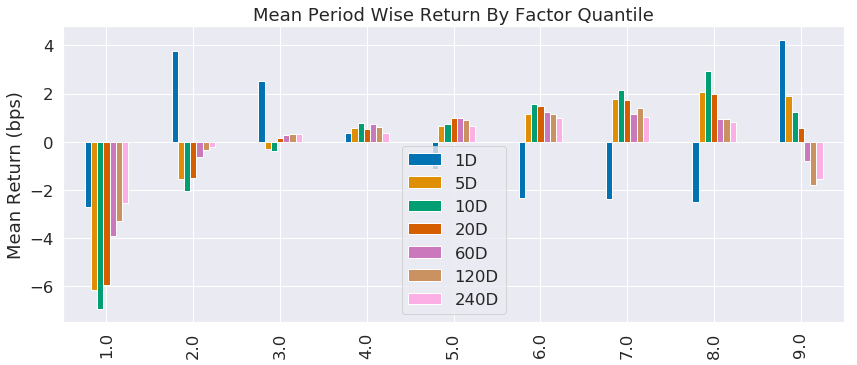

In [13]:
alphalens.tears.create_summary_tear_sheet(fir_factor_data)

In [14]:
sec_score_alphalens = cal_sharpe_mom([60],pivotdata,bond_price)

In [15]:
scores_pivot = pd.pivot_table(sec_score_alphalens,values='tot_sh',index='date',columns='symbol')
scores_pivot = scores_pivot[1:]
labeled_scores_pivot = scores_pivot.transform(lambda x: pd.qcut(x,9,labels=list(range(1,10)),duplicates='drop'),axis=1)

In [16]:
sec_scores_alphalens = scores_to_alphalens(labeled_scores_pivot)

In [17]:
sec_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor=sec_scores_alphalens,prices=pivotdata,quantiles=9 ,periods=(1,5,10,20,60,120,240),max_loss=41.0)

Dropped 38.8% entries from factor data: 29.9% in forward returns computation and 8.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 4100.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,1.0,2.0,1.000691,0.026279,156276,11.215517
2.0,2.0,3.0,2.000705,0.026547,154559,11.092292
3.0,3.0,4.0,3.001807,0.042470,154956,11.120784
4.0,4.0,5.0,4.002910,0.053867,154289,11.072915
5.0,5.0,6.0,5.001202,0.034654,153863,11.042342
6.0,6.0,6.0,6.000000,0.000000,154984,11.122793
7.0,7.0,8.0,7.000936,0.030576,153885,11.043921
8.0,8.0,8.0,8.000000,0.000000,154412,11.081742
9.0,9.0,9.0,9.000000,0.000000,156167,11.207694


Returns Analysis


,1D,5D,10D,20D,60D,120D,240D
Ann. alpha,0.014,0.048,0.052,0.045,0.027,0.017,0.022
beta,-0.039,-0.060,-0.056,-0.060,-0.022,-0.006,-0.013
Mean Period Wise Return Top Quantile (bps),1.348,0.588,-0.218,-1.151,-2.627,-3.889,-3.630
Mean Period Wise Return Bottom Quantile (bps),-1.023,-3.395,-4.322,-4.237,-4.398,-4.700,-4.852
Mean Period Wise Spread (bps),2.371,3.857,3.942,2.938,1.648,0.663,0.426


/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Information Analysis


,1D,5D,10D,20D,60D,120D,240D
IC Mean,-0.017,-0.006,-0.000,0.004,0.007,0.011,0.021
IC Std.,0.113,0.126,0.130,0.136,0.139,0.127,0.130
Risk-Adjusted IC,-0.147,-0.044,-0.002,0.028,0.051,0.083,0.160
t-stat(IC),NaN,-2.628,-0.129,1.637,3.037,4.958,9.497
p-value(IC),NaN,0.009,0.897,0.102,0.002,0.000,0.000
IC Skew,NaN,-0.163,-0.289,-0.487,-0.292,-0.041,-0.185
IC Kurtosis,NaN,0.532,0.474,0.675,0.173,0.011,0.254


/home/ibrahim/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Turnover Analysis


,10D,120D,1D,20D,240D,5D,60D
Quantile 1 Mean Turnover,0.355,0.811,0.122,0.497,0.820,0.258,0.804
Quantile 2 Mean Turnover,0.638,0.878,0.307,0.746,0.886,0.531,0.890
Quantile 3 Mean Turnover,0.707,0.879,0.398,0.793,0.886,0.617,0.881
Quantile 4 Mean Turnover,0.737,0.878,0.438,0.810,0.889,0.655,0.871
Quantile 5 Mean Turnover,0.745,0.875,0.439,0.814,0.883,0.661,0.869
Quantile 6 Mean Turnover,0.734,0.872,0.409,0.808,0.878,0.642,0.881
Quantile 7 Mean Turnover,0.703,0.882,0.358,0.793,0.881,0.601,0.887
Quantile 8 Mean Turnover,0.617,0.879,0.265,0.730,0.881,0.500,0.874
Quantile 9 Mean Turnover,0.332,0.875,0.102,0.480,0.883,0.230,0.849


,1D,5D,10D,20D,60D,120D,240D
Mean Factor Rank Autocorrelation,0.962,0.875,0.782,0.61,0.02,0.027,0.049


<Figure size 432x288 with 0 Axes>

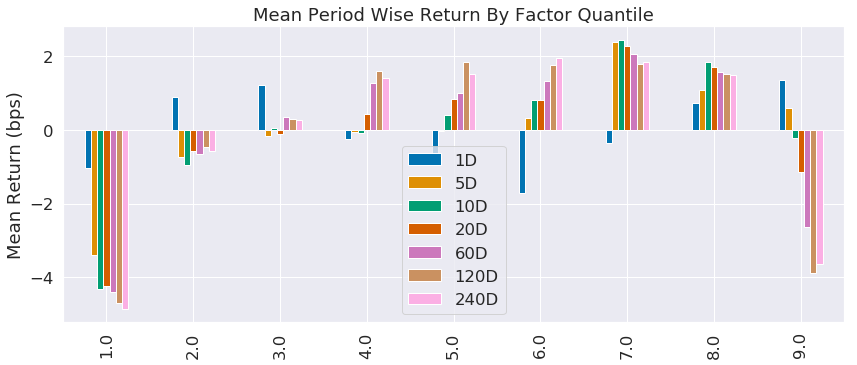

In [18]:
alphalens.tears.create_summary_tear_sheet(sec_factor_data)

In [24]:
thr_score_alphalens = cal_sharpe_mom([240],pivotdata,bond_price)

In [25]:
scores_pivot = pd.pivot_table(thr_score_alphalens,values='tot_sh',index='date',columns='symbol')
scores_pivot = scores_pivot[1:]
labeled_scores_pivot = scores_pivot.transform(lambda x: pd.qcut(x,9,labels=list(range(1,10)),duplicates='drop'),axis=1)

In [26]:
thr_scores_alphalens = scores_to_alphalens(labeled_scores_pivot)

In [27]:
thr_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor=thr_scores_alphalens,prices=pivotdata,quantiles=9 ,periods=(1,5,10,20,60,120,240),max_loss=40.0)

Dropped 37.5% entries from factor data: 29.9% in forward returns computation and 7.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 4000.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,1.0,2.0,1.000732,0.027038,150362,11.218324
2.0,2.0,3.0,2.002779,0.052648,148948,11.112827
3.0,3.0,3.0,3.000000,0.000000,148470,11.077164
4.0,4.0,5.0,4.000741,0.027218,148375,11.070076
5.0,5.0,6.0,5.004208,0.064736,148749,11.097980
6.0,6.0,7.0,6.002182,0.046659,148960,11.113722
7.0,7.0,8.0,7.000792,0.028136,147680,11.018223
8.0,8.0,8.0,8.000000,0.000000,148528,11.081491
9.0,9.0,9.0,9.000000,0.000000,150253,11.210192


Returns Analysis


,1D,5D,10D,20D,60D,120D,240D
Ann. alpha,-0.009,0.006,0.016,0.022,0.021,0.024,0.008
beta,0.022,0.007,-0.008,-0.022,-0.005,0.005,0.097
Mean Period Wise Return Top Quantile (bps),-3.484,-3.870,-3.791,-4.403,-5.284,-5.247,-4.310
Mean Period Wise Return Bottom Quantile (bps),-1.081,-3.073,-3.889,-4.453,-5.682,-6.659,-7.170
Mean Period Wise Spread (bps),-2.403,-0.890,-0.035,-0.091,0.293,1.304,3.042


/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ibrahim/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Information Analysis


,1D,5D,10D,20D,60D,120D,240D
IC Mean,-0.010,-0.002,0.004,0.010,0.021,0.026,0.021
IC Std.,0.098,0.110,0.118,0.128,0.136,0.131,0.124
Risk-Adjusted IC,-0.104,-0.014,0.032,0.075,0.151,0.199,0.167
t-stat(IC),NaN,-0.847,1.867,4.400,8.874,11.691,9.812
p-value(IC),NaN,0.397,0.062,0.000,0.000,0.000,0.000
IC Skew,NaN,-0.166,-0.211,-0.305,-0.026,0.170,-0.150
IC Kurtosis,NaN,0.123,0.190,0.340,0.519,0.506,0.160


/home/ibrahim/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Turnover Analysis


,10D,120D,1D,20D,240D,5D,60D
Quantile 1 Mean Turnover,0.165,0.548,0.057,0.233,0.730,0.118,0.397
Quantile 2 Mean Turnover,0.388,0.785,0.153,0.495,0.885,0.299,0.676
Quantile 3 Mean Turnover,0.492,0.826,0.209,0.602,0.890,0.392,0.753
Quantile 4 Mean Turnover,0.539,0.839,0.239,0.647,0.885,0.437,0.781
Quantile 5 Mean Turnover,0.550,0.843,0.245,0.654,0.872,0.446,0.784
Quantile 6 Mean Turnover,0.540,0.843,0.233,0.648,0.876,0.433,0.782
Quantile 7 Mean Turnover,0.502,0.834,0.205,0.616,0.884,0.397,0.765
Quantile 8 Mean Turnover,0.413,0.805,0.154,0.528,0.879,0.312,0.702
Quantile 9 Mean Turnover,0.186,0.672,0.061,0.268,0.905,0.131,0.473


,1D,5D,10D,20D,60D,120D,240D
Mean Factor Rank Autocorrelation,0.985,0.959,0.931,0.881,0.706,0.468,0.045


<Figure size 432x288 with 0 Axes>

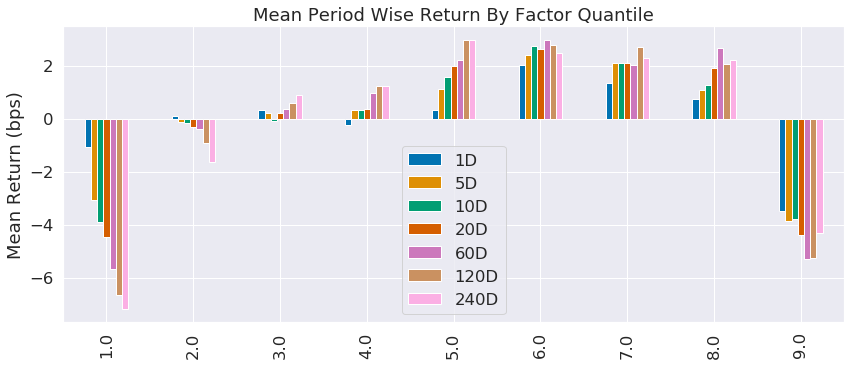

In [28]:
alphalens.tears.create_summary_tear_sheet(thr_factor_data)